In [1]:
!pip install translate
!pip install advertools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 kB 7.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.4/286.4 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 6.3 MB/s eta 0:00:00


In [2]:
from nltk.tokenize import sent_tokenize,word_tokenize,TweetTokenizer
from nltk.probability import FreqDist
import advertools as adv
from pathlib import Path
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn import linear_model

import codecs
import nltk
nltk.download('punkt')
import re
import emoji

from nltk.corpus import stopwords
from collections import Counter

from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok
from nltk.tokenize.treebank import TreebankWordDetokenizer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/sentiment/dataset.csv')
df.head()

,text,label
0,Java the best language.,0.0
1,"""This channel used to be good, now it's all ab...",1.0
2,"""Fake news! Your facts are completely wrong.""",1.0
3,"""Thumbs down for this biased content.""",1.0
4,We really meed to get to 100000 likes on this ...,0.0


0                              Java the best language.
1    "This channel used to be good, now it's all ab...
2        "Fake news! Your facts are completely wrong."
3               "Thumbs down for this biased content."
4    We really meed to get to 100000 likes on this ...
5    it's sad how this video still doesn't have 100...
6    I'm curious if anyone has an opinion on this; ...
7                   I have no idea what this jargon is
8    This video is trash! The content creator shoul...
9      Why do people watch this garbage? Unsubscribed.
Name: text, dtype: object


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:2953: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


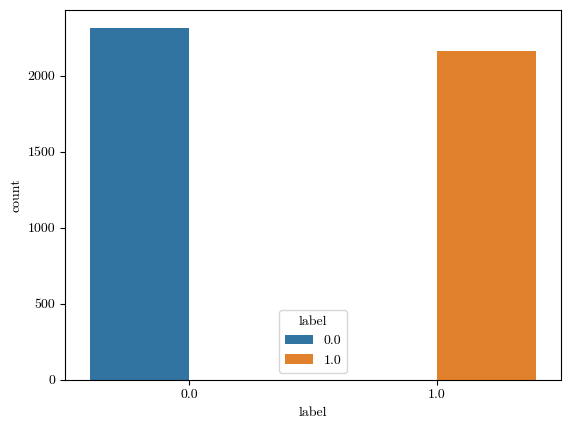

In [4]:
print(df['text'].head(10))
plt.rcParams['font.sans-serif']= "cmr10"
sns.countplot(x='label',hue='label',data=df)
plt.show()

Drop duplicates

In [5]:
# identify the duplicate rows based on the 'comment' column
duplicate_rows = df[df.duplicated(subset=['text'], keep=False)]

# drop the duplicate rows
df = df.drop(duplicate_rows.index)

df.head()

,text,label
0,Java the best language.,0.0
1,"""This channel used to be good, now it's all ab...",1.0
2,"""Fake news! Your facts are completely wrong.""",1.0
3,"""Thumbs down for this biased content.""",1.0
4,We really meed to get to 100000 likes on this ...,0.0


In [6]:
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))
print(stopwords_set)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'yourself', 'for', 'nor', 're', 'about', "you'd", "hasn't", 'if', 'because', 'as', 'she', 'while', 'his', 'this', 'can', 'haven', 'didn', "couldn't", 'doesn', 'hasn', 'it', 'where', 'under', 'out', 'those', 'further', 'here', 'so', "don't", 'am', 'ourselves', 'me', 'now', 'again', "didn't", "haven't", 'wasn', 'd', "isn't", 'once', 'were', 'own', 'doing', 'the', 'i', 'who', 'himself', 'into', 'weren', 'both', 'y', 'do', 'above', 'than', 'won', 'some', 'he', 'be', "should've", 'mustn', 'm', "doesn't", 'when', "aren't", "shouldn't", 'has', "weren't", 'ain', 'by', 'after', "you've", 'hadn', 'him', 'them', 'until', "won't", 'below', 'these', 'being', 'have', 'did', 'such', 'each', 'does', 'don', "mustn't", 'hers', 'no', 'their', 'mightn', 'to', 'will', 'herself', 'themselves', 'at', 'yours', 'or', 'down', 's', 'been', 'they', 'why', "she's", "shan't", 'on', 'most', 'w

In [7]:
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords_set]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

df['text'] = df['text'].apply(remove_stopwords)
df

,text,label
0,Java best language .,0.0
1,"`` This channel used good , 's money . ''",1.0
2,`` Fake news ! Your facts completely wrong . '',1.0
3,`` Thumbs biased content . '',1.0
4,We really meed get 100000 likes vid . I wan na...,0.0
...,...,...
4457,`` Your argument n't seem consider potential r...,1.0
4458,`` It 's crucial acknowledge complexity issue ...,1.0
4459,`` I respectfully challenge assumptions underl...,1.0
4465,`` I 'm convinced evidence 've presented . '',1.0


In [8]:
#%%data cleaning , tokenizing and POS tagging

def clean_data(dataframe):
    # Drop duplicate rows
    dataframe.drop_duplicates(subset='text', inplace=True)
    #replace URL of a text
    dataframe['text'] = dataframe['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '')
    #replace mention
    dataframe['text'] = dataframe['text'].str.replace('#|@\w*','')
    #remove numbers
    dataframe['text'] = dataframe['text'].str.replace('\d+','')

    #punctuation removal 
    string_text = dataframe['text'].str  # get a string accessor for the 'Text_cleaned' column
    punctuation_to_remove = string.punctuation.replace('?', '')  # remove '?' from the punctuation string
    translator = str.maketrans('', '', punctuation_to_remove)  # create a translation table to remove punctuation
    dataframe['text'] = string_text.translate(translator)  # apply the translation table to remove punctuation

    # coerced entire coloumn to str dtype
    dataframe['text'] = dataframe['text'].astype(str)
    
    #print("New shape:", dataframe.shape)
    return dataframe.head()

clean_data(df)
df

,text,label
0,Java best language,0.0
1,This channel used good s money,1.0
2,Fake news Your facts completely wrong,1.0
3,Thumbs biased content,1.0
4,We really meed get 100000 likes vid I wan na ...,0.0
...,...,...
4457,Your argument nt seem consider potential rami...,1.0
4458,It s crucial acknowledge complexity issue,1.0
4459,I respectfully challenge assumptions underlie...,1.0
4465,I m convinced evidence ve presented,1.0


Remove numbers

In [9]:
def remove_numbers(text):
    return re.sub(r'\d', '', text)

# Apply the function to the 'text' column
df['text'] = df['text'].apply(remove_numbers)

Remove emojies

In [10]:
#remove emojies
df['text'] = df['text'].apply(lambda s: emoji.replace_emoji(s, ''))
df

,text,label
0,Java best language,0.0
1,This channel used good s money,1.0
2,Fake news Your facts completely wrong,1.0
3,Thumbs biased content,1.0
4,We really meed get likes vid I wan na see Fi...,0.0
...,...,...
4457,Your argument nt seem consider potential rami...,1.0
4458,It s crucial acknowledge complexity issue,1.0
4459,I respectfully challenge assumptions underlie...,1.0
4465,I m convinced evidence ve presented,1.0


Remove spaces before texts

In [11]:
# Remove leading spaces before text in the specified column
df['text'] = df['text'].str.lstrip()

# Save the cleaned DataFrame to a new CSV file
df.to_csv('cleaned_dataset.csv', index=False)
df

,text,label
0,Java best language,0.0
1,This channel used good s money,1.0
2,Fake news Your facts completely wrong,1.0
3,Thumbs biased content,1.0
4,We really meed get likes vid I wan na see Fi...,0.0
...,...,...
4457,Your argument nt seem consider potential ramif...,1.0
4458,It s crucial acknowledge complexity issue,1.0
4459,I respectfully challenge assumptions underlie ...,1.0
4465,I m convinced evidence ve presented,1.0


In [12]:
# Assuming you have a DataFrame df
empty_text_count = df['text'].isna().sum()

# Print the count of empty 'text' values
print("Number of empty 'text' values:", empty_text_count)

Number of empty 'text' values: 0


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:2953: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


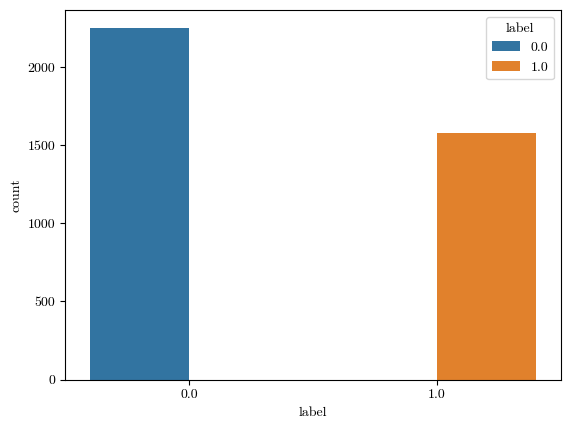

In [13]:
plt.rcParams['font.sans-serif']= "cmr10"
sns.countplot(x='label',hue='label',data=df)
plt.show()